In [2]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 2 methods)

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [7]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_raw_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [8]:
first(x_raw_df, 5)

,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,10.7561,51.3217,117.941,1.58493,1.80198,54.7152,46.9082,-73.5071,-40.3815
2,10.9999,59.0984,114.967,1.42384,1.632,94.2397,329.885,-69.9227,-61.021
3,10.5114,67.2372,102.822,1.56805,1.76104,232.236,482.175,-34.481,-31.0546
4,9.79078,132.062,157.89,1.06108,1.4818,91.7427,178.76,-35.0063,-28.2593
5,10.8851,33.3697,144.044,1.67219,1.83251,433.296,420.627,-32.8443,-26.0774


In [9]:
first(y_raw_df, 5)

,OBJ1,OBJ2,OBJ3,OBJ4,OBJ5,OBJ6
,Float32,Float32,Float32,Float32,Float32,Float32
1,91.0,0.0624,99.34,0.07639,0.07035,0.05352
2,92.69,0.0579,110.26,0.07544,0.03639,0.05048
3,70.87,0.0649,80.55,0.07192,0.04194,0.02244
4,16.85,0.0756,183.99,0.01274,0.01483,0.01153
5,66.16,0.0674,56.7,0.06682,0.03004,0.04468


## EDA

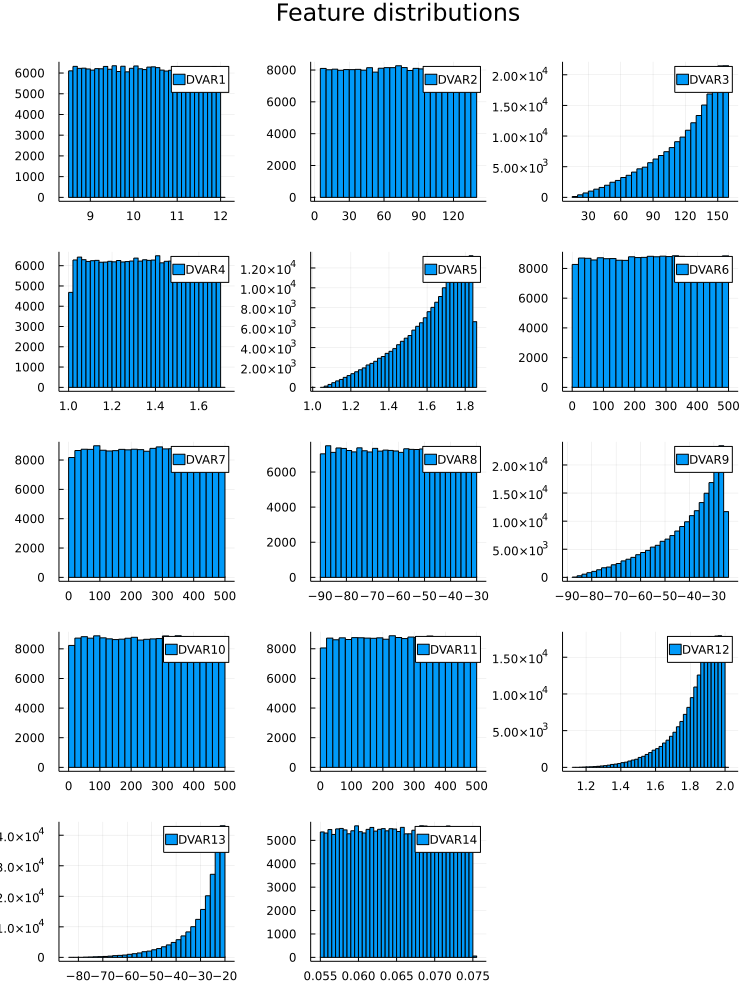

In [10]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_raw_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

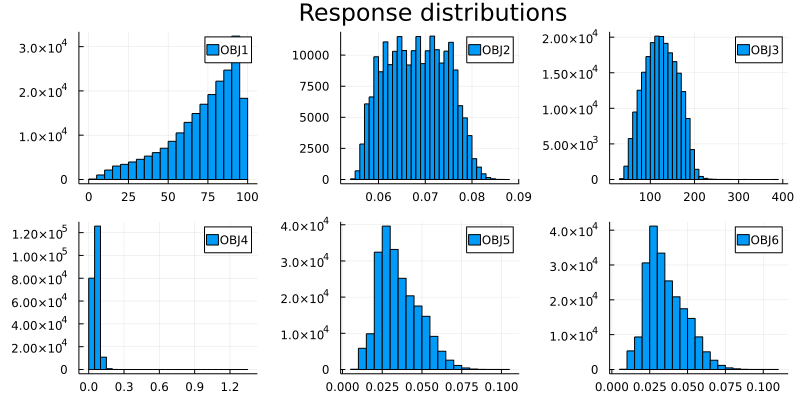

In [11]:
# plot responses
l = @layout [grid(2,3)]

subplots = []
for i in 1:6
    hist = histogram(y_raw_df[:, "OBJ$i"], label="OBJ$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout = l, size=(800, 400), plot_title="Response distributions")

In [12]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [13]:
# how many outliers are there?
sum((!).(non_outlier_conditional))

717

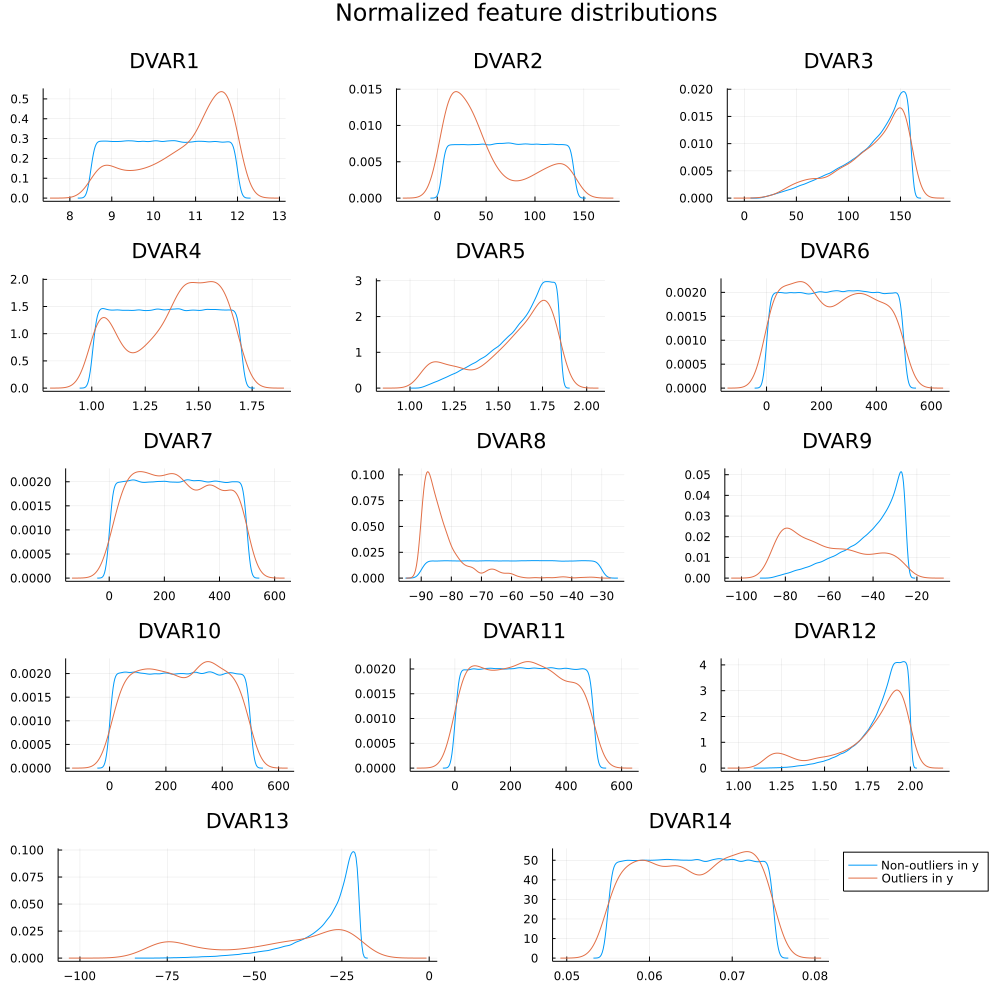

In [14]:
# features split by outlier
l = @layout [a b c; d e f; g h i; j k l; m n]

subplots = []
for i in 1:14
    sp = density(x_df[:, "DVAR$i"]; label=(i == 14 ? "Non-outliers in y" : ""), legend=(i==14), title="DVAR$i")
    density!(sp, x_outliers_df[:, "DVAR$i"]; label=(i == 14 ? "Outliers in y" : ""), legend=:outertopright)
    push!(subplots, sp)
end

plot(subplots..., layout=l, size=(1000, 1000), plot_title="Normalized feature distributions")

## Data preprocessing

In [15]:
# scaler
mutable struct MinMaxScaler
    data_min::Float64
    data_max::Float64
end

function fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    fit!(scaler, data)
    transform(scaler, data)
end

# sanity checking
data_test = [1., 2., 3., 4., 5.]
scaler_test = MinMaxScaler(0., 0.)
fit!(scaler_test, data_test)
data_test_scaled = transform(scaler_test, data_test)
@assert(maximum(data_test_scaled) == 1.0)
@assert(minimum(data_test_scaled) == -1.0)
@assert(maximum(data_test) == maximum(inverse_transform(scaler_test, data_test_scaled)))
@assert(minimum(data_test) == minimum(inverse_transform(scaler_test, data_test_scaled)))

LoadError: invalid redefinition of type MinMaxScaler

In [16]:
# drop any columns needed
select!(x_df, Not(x_columns_to_drop));
select!(y_df, Not(y_columns_to_drop));

In [17]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [18]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [19]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [20]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [21]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [75]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [76]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=21.241119869053364
epoch 2, loss=10.444883849471807
epoch 3, loss=6.0593022108078
epoch 4, loss=4.785429717972875
epoch 5, loss=4.199761129915714
epoch 6, loss=3.9565930031239986
epoch 7, loss=3.7731754444539547
epoch 8, loss=3.6090305391699076
epoch 9, loss=3.4412295073270798
epoch 10, loss=3.28241122700274
epoch 11, loss=3.13847710005939
epoch 12, loss=3.044311385601759
epoch 13, loss=2.957357781007886
epoch 14, loss=2.8812963869422674
epoch 15, loss=2.821392604149878
epoch 16, loss=2.753813626244664
epoch 17, loss=2.695312445051968
epoch 18, loss=2.6488608876243234
epoch 19, loss=2.609798774123192
epoch 20, loss=2.59183338470757
epoch 21, loss=2.559910857118666
epoch 22, loss=2.496187513694167
epoch 23, loss=2.4793324917554855
epoch 24, loss=2.4533694740384817
epoch 25, loss=2.4142471393570304
epoch 26, loss=2.3685376727953553
epoch 27, loss=2.3413722943514585
epoch 28, loss=2.3076852848753333
epoch 29, loss=2.287400048226118
epoch 30, loss=2.2513003796339035
epoch 31,

epoch 241, loss=1.590614971704781
epoch 242, loss=1.6106719467788935
epoch 243, loss=1.638203359209001
epoch 244, loss=1.6016316451132298
epoch 245, loss=1.5914835259318352
epoch 246, loss=1.5857437057420611
epoch 247, loss=1.6132287438958883
epoch 248, loss=1.5892219459638
epoch 249, loss=1.5939856246113777
epoch 250, loss=1.5888059679418802
epoch 251, loss=1.6261896416544914
epoch 252, loss=1.5841061901301146
epoch 253, loss=1.6017281357198954
epoch 254, loss=1.588398352265358
epoch 255, loss=1.5865699611604214
epoch 256, loss=1.6079983487725258
epoch 257, loss=1.5880073122680187
epoch 258, loss=1.5803284449502826
epoch 259, loss=1.5843436904251575
epoch 260, loss=1.5878392038866878
epoch 261, loss=1.5963822193443775
epoch 262, loss=1.5805883323773742
epoch 263, loss=1.5786888059228659
epoch 264, loss=1.6075774217024446
epoch 265, loss=1.6031024809926748
epoch 266, loss=1.586976921185851
epoch 267, loss=1.5787143670022488
epoch 268, loss=1.5768989296630025
epoch 269, loss=1.582847890

epoch 477, loss=1.53695088904351
epoch 478, loss=1.5507261967286468
epoch 479, loss=1.536995298229158
epoch 480, loss=1.5314567415043712
epoch 481, loss=1.536757399328053
epoch 482, loss=1.5309206545352936
epoch 483, loss=1.5394790088757873
epoch 484, loss=1.5367367323487997
epoch 485, loss=1.5359256071969867
epoch 486, loss=1.5306054325774312
epoch 487, loss=1.5375817622989416
epoch 488, loss=1.533368168398738
epoch 489, loss=1.5380926001816988
epoch 490, loss=1.530591782182455
epoch 491, loss=1.556606630794704
epoch 492, loss=1.5274996012449265
epoch 493, loss=1.5345662897452712
epoch 494, loss=1.5585932824760675
epoch 495, loss=1.5325221316888928
epoch 496, loss=1.5393853513523936
epoch 497, loss=1.5445150136947632
epoch 498, loss=1.540568164549768
epoch 499, loss=1.5406557358801365
epoch 500, loss=1.539767381735146
epoch 501, loss=1.5329760489985347
epoch 502, loss=1.524591070599854
epoch 503, loss=1.5297815026715398
epoch 504, loss=1.5296318549662828
epoch 505, loss=1.528488275595

epoch 713, loss=1.5102138705551624
epoch 714, loss=1.4958492694422603
epoch 715, loss=1.4958962770178914
epoch 716, loss=1.4964916920289397
epoch 717, loss=1.496230214368552
epoch 718, loss=1.496467507444322
epoch 719, loss=1.494848856702447
epoch 720, loss=1.4889935166575015
epoch 721, loss=1.4897930203005672
epoch 722, loss=1.5206413259729743
epoch 723, loss=1.4991932678967714
epoch 724, loss=1.4971687756478786
epoch 725, loss=1.495677680708468
epoch 726, loss=1.49101188685745
epoch 727, loss=1.5000078296288848
epoch 728, loss=1.489444524049759
epoch 729, loss=1.4999055145308375
epoch 730, loss=1.5059534152969718
epoch 731, loss=1.4916186910122633
epoch 732, loss=1.5023145293816924
epoch 733, loss=1.5052074901759624
epoch 734, loss=1.4935481790453196
epoch 735, loss=1.5084332572296262
epoch 736, loss=1.4877859596163034
epoch 737, loss=1.4904172895476222
epoch 738, loss=1.4979627868160605
epoch 739, loss=1.4947161171585321
epoch 740, loss=1.4963782569393516
epoch 741, loss=1.491871971

epoch 949, loss=1.4672756101936102
epoch 950, loss=1.4710839688777924
epoch 951, loss=1.4720428115688264
epoch 952, loss=1.465695746243
epoch 953, loss=1.4839451685547829
epoch 954, loss=1.477190000936389
epoch 955, loss=1.478816513903439
epoch 956, loss=1.4643860086798668
epoch 957, loss=1.4679762069135904
epoch 958, loss=1.4758963705971837
epoch 959, loss=1.4644570173695683
epoch 960, loss=1.4713775739073753
epoch 961, loss=1.4774799831211567
epoch 962, loss=1.472502339631319
epoch 963, loss=1.4711711923591793
epoch 964, loss=1.4815769642591476
epoch 965, loss=1.4770240988582373
epoch 966, loss=1.4675687300041318
epoch 967, loss=1.4655433823354542
epoch 968, loss=1.4651663466356695
epoch 969, loss=1.4670399795286357
epoch 970, loss=1.4701241520233452
epoch 971, loss=1.4731783550232649
epoch 972, loss=1.4695689901709557
epoch 973, loss=1.4632715815678239
epoch 974, loss=1.464613732881844
epoch 975, loss=1.4709108052775264
epoch 976, loss=1.4674340961501002
epoch 977, loss=1.4669262534

epoch 1179, loss=1.4630002556368709
epoch 1180, loss=1.4469925658777356
epoch 1181, loss=1.448823000304401
epoch 1182, loss=1.4497467912733555
epoch 1183, loss=1.4571749586611986
epoch 1184, loss=1.4550527846440673
epoch 1185, loss=1.4499733201228082
epoch 1186, loss=1.4498615227639675
epoch 1187, loss=1.4422759520821273
epoch 1188, loss=1.444923421368003
epoch 1189, loss=1.4542954238131642
epoch 1190, loss=1.4516071933321655
epoch 1191, loss=1.4504190157167614
epoch 1192, loss=1.446345018222928
epoch 1193, loss=1.4563292539678514
epoch 1194, loss=1.458372438326478
epoch 1195, loss=1.4703068067319691
epoch 1196, loss=1.4651976469904184
epoch 1197, loss=1.4582022679969668
epoch 1198, loss=1.4510925868526101
epoch 1199, loss=1.4504410135559738
epoch 1200, loss=1.4444284699857235
epoch 1201, loss=1.449960776604712
epoch 1202, loss=1.4507938553579152
epoch 1203, loss=1.4475978594273329
epoch 1204, loss=1.4455726817250252
epoch 1205, loss=1.4574598222970963
epoch 1206, loss=1.44405567506328

LoadError: InterruptException:

In [94]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

BoundsError: BoundsError: attempt to access 1393-element Vector{Float32} at index [1:2500]

## Model evaluation

In [78]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [79]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.92811126
r2 on test set: 0.9284406


In [80]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 4 methods)

In [81]:
size(x_train, 2)

14

In [82]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.92810535
adjustedr2 on test set: 0.9284174


In [83]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.06238916
mae on test set: 0.06224538


In [84]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.02460914
mae on test set for OBJ1: 0.024549993
mae on training set for OBJ2: 0.07492777
mae on test set for OBJ2: 0.07513569
mae on training set for OBJ3: 0.017346784
mae on test set for OBJ3: 0.017441643
mae on training set for OBJ4: 0.03691063
mae on test set for OBJ4: 0.037104066
mae on training set for OBJ5: 0.11078146
mae on test set for OBJ5: 0.11006343
mae on training set for OBJ6: 0.10975915
mae on test set for OBJ6: 0.10917745


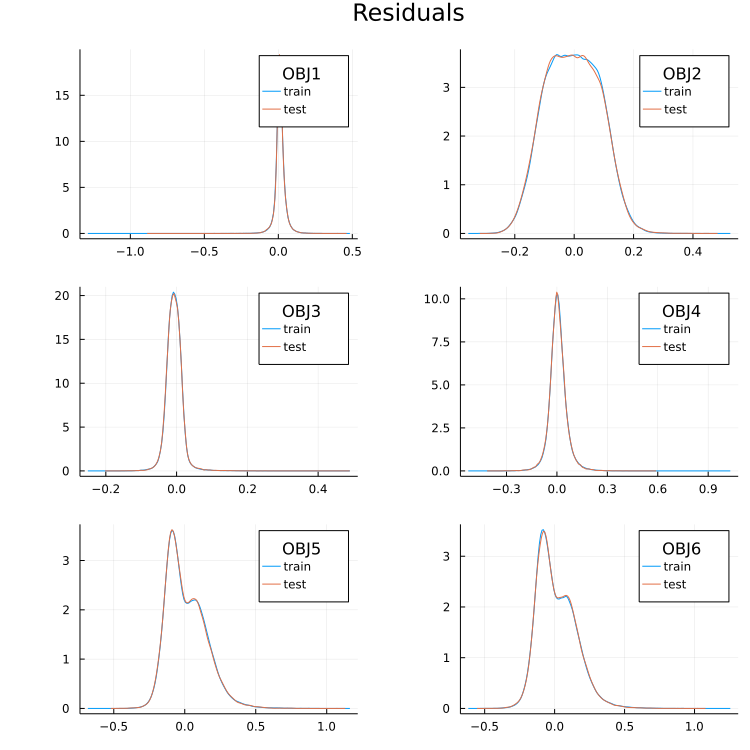

In [85]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

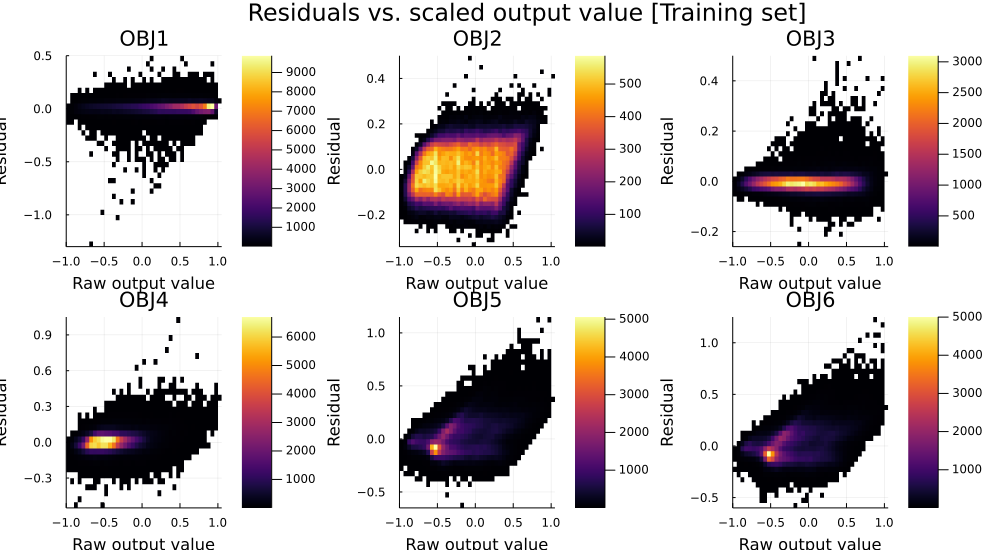

In [86]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

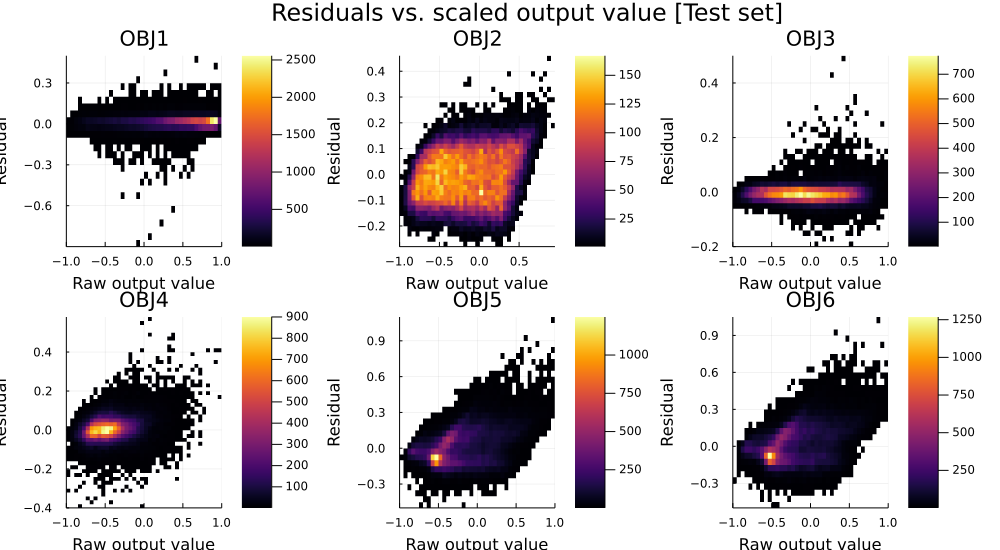

In [87]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")

## Creating Hierarchical Neural Networks

For a proof-of-concept, I choose Energy (Objective 2).

For each input $\mathbf{x}_i \in \mathbb{R}^{14}$, our neural network created above is a function $\mathbf{f}$ such that we can generate predictions $\hat{\mathbf{y}}_i = \mathbf{f}(\mathbf{x}_i), \mathbf{y}_i \in \mathbb{R}^6$. This neural network was trained to minimize the mean squared error $\sum_i (\mathbf{y}_i - \hat{\mathbf{y}}_i)^2$.

Now I create a second neural network with inputs $\mathbf{x}_i, \hat{y}_{i}$, where $\hat{y}_i$ is the prediction from the first neural network.

In [88]:
component = 2
v_dimension = 20 # can automate later

# build the model
function energyneuralnetwork()
    Chain(
        Dense(v_dimension, 10, x->σ.(x)),
        Dense(10, 10, x->σ.(x)),
        Dense(10, 5, x->σ.(x)),
        Dense(5, 5, x->σ.(x)),
        Dense(5, 1)
    )
end

energyneuralnetwork (generic function with 1 method)

In [89]:
# make data
v_train = hcat(x_train, y_train_preds);
v_test = hcat(x_test, y_test_preds);

y2_train = y_train[:, component];
y2_test = y_train[:, component];

In [90]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((v_train', y2_train'), batchsize=batch_size, shuffle=true);

In [91]:
# defining our model, optimization algorithm and loss function
m2 = energyneuralnetwork()
optimizer = ADAM(0.0001)
loss(x, y) = Flux.mse(m2(x), y)

# training
n_epochs = 2500
training_losses_2 = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m2), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses_2, l)
end

epoch 1, loss=40.969623029232025
epoch 2, loss=33.95095957815647
epoch 3, loss=29.722110465168953
epoch 4, loss=27.31409876048565
epoch 5, loss=26.061244428157806
epoch 6, loss=25.48374366760254
epoch 7, loss=25.234848022460938
epoch 8, loss=25.117943957448006
epoch 9, loss=25.06187042593956
epoch 10, loss=25.020316272974014
epoch 11, loss=24.98206727206707
epoch 12, loss=24.921833142638206
epoch 13, loss=24.857716158032417
epoch 14, loss=24.781446114182472
epoch 15, loss=24.70078931748867
epoch 16, loss=24.590101808309555
epoch 17, loss=24.435094997286797
epoch 18, loss=24.254689186811447
epoch 19, loss=24.03847350180149
epoch 20, loss=23.749009117484093
epoch 21, loss=23.39469787478447
epoch 22, loss=22.9222462028265
epoch 23, loss=22.322552397847176
epoch 24, loss=21.564567938447
epoch 25, loss=20.632752135396004
epoch 26, loss=19.507101602852345
epoch 27, loss=18.1913668140769
epoch 28, loss=16.702697038650513
epoch 29, loss=15.075775243341923
epoch 30, loss=13.34506618976593
epoch

epoch 241, loss=1.400599411688745
epoch 242, loss=1.3979479777626693
epoch 243, loss=1.3986368109472096
epoch 244, loss=1.3972823494113982
epoch 245, loss=1.3987215925008059
epoch 246, loss=1.397456806153059
epoch 247, loss=1.3988680583424866
epoch 248, loss=1.3969346145167947
epoch 249, loss=1.3977165706455708
epoch 250, loss=1.3980103344656527
epoch 251, loss=1.3974048402160406
epoch 252, loss=1.397253262810409
epoch 253, loss=1.3992241146042943
epoch 254, loss=1.3976333234459162
epoch 255, loss=1.3958299728110433
epoch 256, loss=1.3967684116214514
epoch 257, loss=1.3966803872026503
epoch 258, loss=1.395550558809191
epoch 259, loss=1.3971906383521855
epoch 260, loss=1.3978840643540025
epoch 261, loss=1.3962521008215845
epoch 262, loss=1.3960894821211696
epoch 263, loss=1.3960640588775277
epoch 264, loss=1.3961556092835963
epoch 265, loss=1.3971513281576335
epoch 266, loss=1.3959542508237064
epoch 267, loss=1.3960238466970623
epoch 268, loss=1.3943528761155903
epoch 269, loss=1.395576

epoch 477, loss=1.3839414790272713
epoch 478, loss=1.3879072619602084
epoch 479, loss=1.3831930961459875
epoch 480, loss=1.3845628146082163
epoch 481, loss=1.383582376409322
epoch 482, loss=1.3838362414389849
epoch 483, loss=1.3841189704835415
epoch 484, loss=1.3867143103852868
epoch 485, loss=1.384186792653054
epoch 486, loss=1.3835354531183839
epoch 487, loss=1.3852097699418664
epoch 488, loss=1.3832935742102563
epoch 489, loss=1.385003318078816
epoch 490, loss=1.3843194139190018
epoch 491, loss=1.384883641730994
epoch 492, loss=1.3841997096315026
epoch 493, loss=1.3827980048954487
epoch 494, loss=1.3851091177202761
epoch 495, loss=1.3827186524868011
epoch 496, loss=1.386397813912481
epoch 497, loss=1.3842521356418729
epoch 498, loss=1.3825590023770928
epoch 499, loss=1.3847308997064829
epoch 500, loss=1.3824446224607527
epoch 501, loss=1.3839400638826191
epoch 502, loss=1.3829139894805849
epoch 503, loss=1.3840895229950547
epoch 504, loss=1.3828945839777589
epoch 505, loss=1.3842946

epoch 713, loss=1.37855139747262
epoch 714, loss=1.3789095212705433
epoch 715, loss=1.3777660466730595
epoch 716, loss=1.3783462871797383
epoch 717, loss=1.3790772524662316
epoch 718, loss=1.3781569567508996
epoch 719, loss=1.3780172364786267
epoch 720, loss=1.3778096353635192
epoch 721, loss=1.3788909311406314
epoch 722, loss=1.3793264743871987
epoch 723, loss=1.3776240260340273
epoch 724, loss=1.379499222151935
epoch 725, loss=1.3777525704354048
epoch 726, loss=1.377740212250501
epoch 727, loss=1.3790995846502483
epoch 728, loss=1.3782923016697168
epoch 729, loss=1.3780206465162337
epoch 730, loss=1.3773939828388393
epoch 731, loss=1.377335153054446
epoch 732, loss=1.3781271749176085
epoch 733, loss=1.3791466332040727
epoch 734, loss=1.3779637152329087
epoch 735, loss=1.3806928200647235
epoch 736, loss=1.377943434752524
epoch 737, loss=1.378103635739535
epoch 738, loss=1.3767960765399039
epoch 739, loss=1.3785407477989793
epoch 740, loss=1.3797036581672728
epoch 741, loss=1.377908774

epoch 949, loss=1.3744573080912232
epoch 950, loss=1.3755503459833562
epoch 951, loss=1.3745466405525804
epoch 952, loss=1.374154049437493
epoch 953, loss=1.3742990647442639
epoch 954, loss=1.374586348887533
epoch 955, loss=1.3742211502976716
epoch 956, loss=1.3740470046177506
epoch 957, loss=1.3744749245233834
epoch 958, loss=1.3755979677662253
epoch 959, loss=1.3732815054245293
epoch 960, loss=1.3748278403654695
epoch 961, loss=1.374154080171138
epoch 962, loss=1.3752682600170374
epoch 963, loss=1.3756451201625168
epoch 964, loss=1.3748415261507034
epoch 965, loss=1.3748101303353906
epoch 966, loss=1.3737287344411016
epoch 967, loss=1.3751075598411262
epoch 968, loss=1.3732490320689976
epoch 969, loss=1.3745888234116137
epoch 970, loss=1.373309651389718
epoch 971, loss=1.3746461137197912
epoch 972, loss=1.3778102397918701
epoch 973, loss=1.3753259223885834
epoch 974, loss=1.373944197781384
epoch 975, loss=1.374871764332056
epoch 976, loss=1.3744278820231557
epoch 977, loss=1.37407243

epoch 1179, loss=1.3710448811762035
epoch 1180, loss=1.3711041673086584
epoch 1181, loss=1.3715461920946836
epoch 1182, loss=1.3718751040287316
epoch 1183, loss=1.3713682959787548
epoch 1184, loss=1.3712915009818971
epoch 1185, loss=1.3725911644287407
epoch 1186, loss=1.3708868618123233
epoch 1187, loss=1.3708697478286922
epoch 1188, loss=1.3723600218072534
epoch 1189, loss=1.3718960639089346
epoch 1190, loss=1.371198482811451
epoch 1191, loss=1.3706673253327608
epoch 1192, loss=1.371328050736338
epoch 1193, loss=1.3707443228922784
epoch 1194, loss=1.372657506261021
epoch 1195, loss=1.3706108662299812
epoch 1196, loss=1.3715050723403692
epoch 1197, loss=1.3740341854281723
epoch 1198, loss=1.3719699564389884
epoch 1199, loss=1.3724153540097177
epoch 1200, loss=1.3709888393059373
epoch 1201, loss=1.3711654976941645
epoch 1202, loss=1.3714288603514433
epoch 1203, loss=1.3744670660234988
epoch 1204, loss=1.3716849968768656
epoch 1205, loss=1.3706639143638313
epoch 1206, loss=1.371379965916

epoch 1408, loss=1.371167866513133
epoch 1409, loss=1.3705995921045542
epoch 1410, loss=1.3709988333284855
epoch 1411, loss=1.3703328082337976
epoch 1412, loss=1.3693961128592491
epoch 1413, loss=1.3702808124944568
epoch 1414, loss=1.3690351517871022
epoch 1415, loss=1.369133929722011
epoch 1416, loss=1.3689790097996593
epoch 1417, loss=1.3693096349015832
epoch 1418, loss=1.369354709982872
epoch 1419, loss=1.3710750369355083
epoch 1420, loss=1.3691059383563697
epoch 1421, loss=1.369898120407015
epoch 1422, loss=1.3694058954715729
epoch 1423, loss=1.3682120386511087
epoch 1424, loss=1.3691925802268088
epoch 1425, loss=1.3692576619796455
epoch 1426, loss=1.3699142024852335
epoch 1427, loss=1.370483276899904
epoch 1428, loss=1.36945038754493
epoch 1429, loss=1.369875444099307
epoch 1430, loss=1.3700638902373612
epoch 1431, loss=1.369099272415042
epoch 1432, loss=1.369160234928131
epoch 1433, loss=1.370415129698813
epoch 1434, loss=1.3701861584559083
epoch 1435, loss=1.3693945491686463
epo

epoch 1637, loss=1.368437665514648
epoch 1638, loss=1.3685592217370868
epoch 1639, loss=1.368305353447795
epoch 1640, loss=1.3685108334757388
epoch 1641, loss=1.368567199446261
epoch 1642, loss=1.368687097914517
epoch 1643, loss=1.367787498049438
epoch 1644, loss=1.3693461678922176
epoch 1645, loss=1.3691130108200014
epoch 1646, loss=1.3691471898928285
epoch 1647, loss=1.3684742846526206
epoch 1648, loss=1.3713023848831654
epoch 1649, loss=1.3682754784822464
epoch 1650, loss=1.3696847488172352
epoch 1651, loss=1.3703362015075982
epoch 1652, loss=1.3689734288491309
epoch 1653, loss=1.3691702014766634
epoch 1654, loss=1.3698108782991767
epoch 1655, loss=1.3693898543715477
epoch 1656, loss=1.3721688776277006
epoch 1657, loss=1.369396182242781
epoch 1658, loss=1.369300634600222
epoch 1659, loss=1.369676728732884
epoch 1660, loss=1.3683598865754902
epoch 1661, loss=1.3699016319587827
epoch 1662, loss=1.3691470138728619
epoch 1663, loss=1.3686160389333963
epoch 1664, loss=1.3689477387815714


epoch 1866, loss=1.3688584784977138
epoch 1867, loss=1.3689090237021446
epoch 1868, loss=1.368296476546675
epoch 1869, loss=1.3685322939418256
epoch 1870, loss=1.370283041615039
epoch 1871, loss=1.3692444111220539
epoch 1872, loss=1.3685749806463718
epoch 1873, loss=1.370163829997182
epoch 1874, loss=1.369010525289923
epoch 1875, loss=1.367928074207157
epoch 1876, loss=1.3685880554839969
epoch 1877, loss=1.3681892910972238
epoch 1878, loss=1.3682624869979918
epoch 1879, loss=1.3704127371311188
epoch 1880, loss=1.369369373191148
epoch 1881, loss=1.3685467164032161
epoch 1882, loss=1.3684378247708082
epoch 1883, loss=1.3680461426265538
epoch 1884, loss=1.3693186449818313
epoch 1885, loss=1.3690258762799203
epoch 1886, loss=1.3689966890960932
epoch 1887, loss=1.3694026204757392
epoch 1888, loss=1.3694982887245715
epoch 1889, loss=1.3692694786004722
epoch 1890, loss=1.367968141566962
epoch 1891, loss=1.3687489521689713
epoch 1892, loss=1.3688700078055263
epoch 1893, loss=1.3684997344389558

epoch 2095, loss=1.3682961235754192
epoch 2096, loss=1.3692167927511036
epoch 2097, loss=1.3688339930959046
epoch 2098, loss=1.368828437756747
epoch 2099, loss=1.3692433633841574
epoch 2100, loss=1.368416480254382
epoch 2101, loss=1.3697435464709997
epoch 2102, loss=1.3711173417977989
epoch 2103, loss=1.3699775533750653
epoch 2104, loss=1.3689477262087166
epoch 2105, loss=1.3695471999235451
epoch 2106, loss=1.3684673612006009
epoch 2107, loss=1.3708368996158242
epoch 2108, loss=1.3701090039685369
epoch 2109, loss=1.3694379669614136
epoch 2110, loss=1.3674536463804543
epoch 2111, loss=1.3684917972423136
epoch 2112, loss=1.3700802265666425
epoch 2113, loss=1.3700836645439267
epoch 2114, loss=1.3694462603889406
epoch 2115, loss=1.3687491142190993
epoch 2116, loss=1.370480195619166
epoch 2117, loss=1.367344593629241
epoch 2118, loss=1.368845981080085
epoch 2119, loss=1.367782395798713
epoch 2120, loss=1.3684978536330163
epoch 2121, loss=1.3683633664622903
epoch 2122, loss=1.368275310378521

epoch 2324, loss=1.3676566719077528
epoch 2325, loss=1.369042169302702
epoch 2326, loss=1.3691440713591874
epoch 2327, loss=1.3685084646567702
epoch 2328, loss=1.3679209128022194
epoch 2329, loss=1.3689776412211359
epoch 2330, loss=1.3696223385632038
epoch 2331, loss=1.3686745753511786
epoch 2332, loss=1.3672982477582991
epoch 2333, loss=1.3699177731759846
epoch 2334, loss=1.3692506067454815
epoch 2335, loss=1.3706856211647391
epoch 2336, loss=1.3682912150397897
epoch 2337, loss=1.3673968077637255
epoch 2338, loss=1.3688303176313639
epoch 2339, loss=1.3681955612264574
epoch 2340, loss=1.3686522445641458
epoch 2341, loss=1.3681321702897549
epoch 2342, loss=1.3677014918066561
epoch 2343, loss=1.3688089000061154
epoch 2344, loss=1.37169488100335
epoch 2345, loss=1.3693184917792678
epoch 2346, loss=1.368144023232162
epoch 2347, loss=1.3695045500062406
epoch 2348, loss=1.369145059492439
epoch 2349, loss=1.3676467519253492
epoch 2350, loss=1.3685792642645538
epoch 2351, loss=1.36792373890057

In [92]:
# before second neural network
r2_train_2 = r2score(y_train[:,component], m(x_train')'[:, component])
r2_test_2 = r2score(y_test[:, component], m(x_test')'[:, component])
println("r2 on training set: $r2_train_2")
println("r2 on test set: $r2_test_2")
# after second neural network
println("after second nn")
r2_train_custom2 = r2score(y_train[:,component], m2(v_train')')
r2_test_custom2 = r2score(y_test[:, component], m2(v_test')')
println("r2 on training set: $r2_train_custom2")
println("r2 on test set: $r2_test_custom2")

r2 on training set: 0.9454436
r2 on test set: 0.94551915
after second nn
r2 on training set: 0.9457889
r2 on test set: 0.94598997


In [93]:
# before second neural network
mae_train_by_dim = Flux.mae(y_train_preds[:,component], y_train[:, component])
mae_test_by_dim = Flux.mae(y_test_preds[:, component], y_test[:, component])
println("mae on training set for OBJ2: $mae_train_by_dim")
println("mae on test set for OBJ2: $mae_test_by_dim")

# after
println("after second nn")
mae_train_by_dim = Flux.mae(m2(v_train')', y_train[:, component])
mae_test_by_dim = Flux.mae(m2(v_test')', y_test[:, component])
println("mae on training set for OBJ2: $mae_train_by_dim")
println("mae on test set for OBJ2: $mae_test_by_dim")

mae on training set for OBJ2: 0.07492777
mae on test set for OBJ2: 0.07513569
after second nn
mae on training set for OBJ2: 0.07472614
mae on test set for OBJ2: 0.07486105
